# TCGA - Breast Cancer Classification
# TABLE OF CONTENTS

1. [INTRODUCTION](#1)

   - [Problem Description](#1.1)
   - [Scope of the Project](#1.2)
   - [Goals](#1.3)

2. [THE DATA](#2)

   - [Data Sources](#2.1)
   - [Data Collection](#2.2)
   - [Feature Description Table](#2.3) 

3. [NORMALIZATION](#3)
 
4. [EXPLORATORY DATA ANALYSIS (EDA)](#4)




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 1. INTRODUCTION <a id='1'></a>

## 1.1 Problem Description <a id='1.1'></a>

Breast cancer remains one of the most prevalent and life-threatening diseases affecting individuals worldwide. This study aims to classify breast cancer stages by examining gene expression variations and predicting patient survival likelihood using transcriptomic data. By leveraging mRNA-seq gene expression profiles from The Cancer Genome Atlas (TCGA), the project will identify key biomarkers for early detection and explore gene-gene interactions influencing cancer progression. A combination of normalization techniques, feature selection methods, and machine learning models will be employed to develop an optimized classification system, with a final goal of integrating survival analysis into a predictive dashboard for clinical insights.

## 1.2 Scope of the Project <a name="1.2"></a>

1. Data Collection: Profile the mRNA-seq gene expression data and clinical information for breast cancer samples from TCGA, integrating them into a single data frame.
2. Data Preprocessing: Explore 3 normalization techniques for gene expression data: RPKM, FPKM, and TPM. After normalization, perform EDA to better understand the data distribution, outliers, and key characteristics, focusing on the behavior of genes across different cancer stages.
3. Feature Selection & Feature Engineering: Apply dimensionality reduction techniques (e.g., PCA, LDA, PCC) for feature selection and investigate transcription factor activities for model input.
4. Model Selection & Training: Train multiple models to predict cancer severity/stage (e.g., Ridge, RF, MLP, XGBoost, and SVM) and compare their performance using cross-validation.
5. Model Evaluation & Optimization: Evaluate models using performance metrics (e.g., accuracy, AUC, F1-score) and optimize the selected model using techniques like hyperparameter tuning or grid search to improve performance.
6. Create a Survival Analysis Dashboard: Develop a survival analysis dashboard leveraging Gradio/Tableau for the interface, PostgreSQL for data storage, and Apache Airflow to schedule and run the ML model for predicting survival probabilities of breast cancer patients.

## 2.2 Goals <a name="2.2"></a>

The goal of this study is to:

- Examine the differences in gene expression across various stages of breast cancer.
- Predict the likelihood of survival for breast cancer patients based on gene expression.
- Identify key biomarkers for the early detection of breast cancer.
- Explore gene-gene interactions and their role in cancer progression.


# 2. THE DATA<a id='2'></a>

## 2.1 Data Sources<a id='2.1'></a>

The dataset is sourced from TCGA human tumor data (transcriptomes) and is focused solely on breast cancer (BRCA) samples from cancer patients. We will be using mRNA-seq gene expression profiles of TCGA breast tumors, which are freely available in the TCGA database in TSV format. It consists of 1,231 breast tissue samples from 1,095 unique patients, with each sample containing 60,660 gene expression measurements. These measurements represent mRNA-seq counts, where higher counts indicate greater gene expression levels.

## 2.3 Data Collection <a name="2.2"></a>

- The TCGA-STAD_RNAseq_sample_info.tsv dataset consists of 97 features and 1,231 observations, providing detailed sample metadata. 

- The TCGA-STAD_RNAseq_sample_assay.tsv dataset contains 60,660 features and 1,231 observations, representing gene expression values across different samples. 

- After merging both datasets using barcodes, the resulting dataset expands to 1,231 observations and 60,757 features. 

- A preliminary check confirms that no duplicate entries and missing values are present in the dataset.

In [2]:
# Load datasets
info_df = pd.read_csv('data/TCGA-STAD_RNAseq_sample_info.tsv', sep='\t')
assay_df = pd.read_csv('data/TCGA-BRCA_tpm_assay_with_gene.tsv', sep='\t')
gene_metadata_df = pd.read_csv('data/TCGA-STAD_RNAseq_gene_metadata.tsv', sep='\t')

# Use gene_name as row labels for assay_df
assay_df.set_index('gene_name', inplace=True)

print("\nInfo Dataset:")
display(info_df.head())

print("\nAssay Dataset:")
display(assay_df.head())

print("\nGene Metadata:")
display(gene_metadata_df.head())


Info Dataset:


,barcode,patient,sample,shortLetterCode,definition,sample_submitter_id,sample_type_id,tumor_descriptor,sample_id,submitter_id,...,paper_tobacco_smoking_history,paper_CNV.Clusters,paper_Mutation.Clusters,paper_DNA.Methylation.Clusters,paper_mRNA.Clusters,paper_miRNA.Clusters,paper_lncRNA.Clusters,paper_Protein.Clusters,paper_PARADIGM.Clusters,paper_Pan.Gyn.Clusters
0,TCGA-A2-A25D-01A-12R-A16F-07,TCGA-A2-A25D,TCGA-A2-A25D-01A,TP,Primary solid Tumor,TCGA-A2-A25D-01A,1,Primary,eda0ff5c-84cf-44cb-888f-0aab17441dfa,TCGA-A2-A25D,...,NaN,C6,C4,C1,C2,C2,C2,C1,C4,C3
1,TCGA-BH-A201-01A-11R-A14M-07,TCGA-BH-A201,TCGA-BH-A201-01A,TP,Primary solid Tumor,TCGA-BH-A201-01A,1,Primary,7893162b-3d19-4c54-86ee-aa4884d84e8a,TCGA-BH-A201,...,NaN,C5,C4,C1,C2,C3,C2,C1,C6,C1
2,TCGA-AC-A23C-01A-12R-A169-07,TCGA-AC-A23C,TCGA-AC-A23C-01A,TP,Primary solid Tumor,TCGA-AC-A23C-01A,1,Primary,9cbd4bd6-244b-4274-a230-a7bd02e79571,TCGA-AC-A23C,...,NaN,C3,C1,C1,C1,C3,C1,C1,C6,C3
3,TCGA-AR-A5QP-01A-11R-A28M-07,TCGA-AR-A5QP,TCGA-AR-A5QP-01A,TP,Primary solid Tumor,TCGA-AR-A5QP-01A,1,Primary,151a1187-e07e-4b76-b2d2-2da133b9116b,TCGA-AR-A5QP,...,NaN,C5,C7,C1,C2,C2,NaN,C2,C6,C1
4,TCGA-C8-A12P-01A-11R-A115-07,TCGA-C8-A12P,TCGA-C8-A12P-01A,TP,Primary solid Tumor,TCGA-C8-A12P-01A,1,Primary,0d5aa7a3-3488-4339-b8f1-e4971912e2bc,TCGA-C8-A12P,...,NaN,C4,C9,C2,C2,C3,C1,C5,C4,C4



Assay Dataset:


,TCGA-A2-A25D-01A,TCGA-BH-A201-01A,TCGA-AC-A23C-01A,TCGA-AR-A5QP-01A,TCGA-C8-A12P-01A,TCGA-BH-A0W3-01A,TCGA-AC-A8OQ-01A,TCGA-BH-A0H6-01A,TCGA-D8-A27V-01A,TCGA-D8-A27M-01A,...,TCGA-AC-A3TM-01A,TCGA-A7-A26J-01A.1,TCGA-LL-A441-01A,TCGA-A7-A13G-01A,TCGA-BH-A0E6-01A,TCGA-LL-A5YP-01A,TCGA-AO-A03L-01A,TCGA-BH-A42T-01A,TCGA-A2-A04W-01A,TCGA-AR-A24O-01A
gene_name,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,45.2678,43.9791,7.9821,65.8113,52.3390,18.7888,8.7632,91.8891,120.9522,29.6228,...,15.7530,5.5927,61.9959,15.2128,77.3596,40.9080,13.4312,29.2894,39.1028,26.2958
ENSG00000000005.6,0.2798,1.1406,3.7920,2.5537,0.0000,0.5592,2.1467,1.4798,0.4127,1.4224,...,0.2099,0.0000,2.5050,0.3401,0.6435,0.3826,0.1297,1.3633,0.0442,2.5254
ENSG00000000419.13,67.8730,117.9486,244.0408,134.5917,162.1673,126.7729,117.2212,94.2877,102.9622,64.4935,...,57.4038,99.7556,195.1906,25.3880,53.7458,168.7081,170.7707,96.3181,103.4823,116.2860
ENSG00000000457.14,9.0817,15.2048,22.4373,14.8402,12.6939,23.8948,5.4068,10.1657,41.8873,13.3118,...,5.1592,16.4717,20.4123,15.7994,4.4847,8.4393,16.3402,9.2308,6.4186,11.2603
ENSG00000000460.17,3.3287,8.3656,8.8192,5.9852,6.6071,11.1475,7.3723,3.7848,9.8573,5.9064,...,2.9170,6.5975,8.8435,4.4041,11.2480,8.5408,9.6066,7.6174,3.1809,6.1790



Gene Metadata:


,source,type,score,phase,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene
0,HAVANA,gene,NaN,NaN,ENSG00000000003.15,protein_coding,TSPAN6,2,HGNC:11858,OTTHUMG00000022002.2
1,HAVANA,gene,NaN,NaN,ENSG00000000005.6,protein_coding,TNMD,2,HGNC:17757,OTTHUMG00000022001.2
2,HAVANA,gene,NaN,NaN,ENSG00000000419.13,protein_coding,DPM1,2,HGNC:3005,OTTHUMG00000032742.2
3,HAVANA,gene,NaN,NaN,ENSG00000000457.14,protein_coding,SCYL3,2,HGNC:19285,OTTHUMG00000035941.6
4,HAVANA,gene,NaN,NaN,ENSG00000000460.17,protein_coding,C1orf112,2,HGNC:25565,OTTHUMG00000035821.9


In [3]:
# Basic Dataset Information
print("\nDataset Information:")
info_df.info()
assay_df.info()
gene_metadata_df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231 entries, 0 to 1230
Data columns (total 97 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   barcode                                    1231 non-null   object 
 1   patient                                    1231 non-null   object 
 2   sample                                     1231 non-null   object 
 3   shortLetterCode                            1231 non-null   object 
 4   definition                                 1231 non-null   object 
 5   sample_submitter_id                        1231 non-null   object 
 6   sample_type_id                             1231 non-null   int64  
 7   tumor_descriptor                           1231 non-null   object 
 8   sample_id                                  1231 non-null   object 
 9   submitter_id                               1231 non-null   object 
 10  sa

In [4]:
# Summary Statistics
print("\nSummary Statistics:")
display(info_df.describe())
display(assay_df.describe())


Summary Statistics:


,sample_type_id,days_to_collection,initial_weight,days_to_diagnosis,treatments,age_at_diagnosis,year_of_diagnosis,sites_of_involvement,age_at_index,days_to_birth,...,days_to_last_follow_up,year_of_birth,paper_days_to_birth,paper_days_to_death,paper_days_to_last_followup,paper_age_at_initial_pathologic_diagnosis,paper_Tumor_Grade,paper_MSI_status,paper_HPV_Status,paper_tobacco_smoking_history
count,1231.000000,1229.000000,1216.000000,1190.000000,0.0,1176.000000,1110.000000,0.0,1230.000000,1214.000000,...,3.0,3.0,1084.000000,152.000000,995.000000,1099.000000,0.0,0.0,0.0,0.0
mean,1.946385,1130.716843,310.907072,70.116807,NaN,21530.009354,2007.763063,NaN,58.280488,-21524.601318,...,906.0,1946.0,-21572.763838,1639.546053,1175.024121,58.424932,NaN,NaN,NaN,NaN
std,2.903945,1495.584209,271.972415,359.140965,NaN,4815.422701,4.256506,NaN,13.277725,4842.015435,...,0.0,0.0,4788.797180,1312.563075,1167.812152,13.146040,NaN,NaN,NaN,NaN
min,1.000000,16.000000,5.000000,0.000000,NaN,9840.000000,1988.000000,NaN,26.000000,-32872.000000,...,906.0,1946.0,-32873.000000,116.000000,-31.000000,26.000000,NaN,NaN,NaN,NaN
25%,1.000000,158.000000,130.000000,0.000000,NaN,17959.250000,2007.000000,NaN,48.000000,-24822.750000,...,906.0,1946.0,-24843.250000,668.250000,436.000000,49.000000,NaN,NaN,NaN,NaN
50%,1.000000,484.000000,220.000000,0.000000,NaN,21472.000000,2009.000000,NaN,58.000000,-21494.500000,...,906.0,1946.0,-21557.000000,1223.000000,761.000000,58.000000,NaN,NaN,NaN,NaN
75%,1.000000,1407.000000,392.500000,0.000000,NaN,24788.750000,2010.000000,NaN,67.000000,-17873.000000,...,906.0,1946.0,-18019.250000,2364.000000,1545.500000,67.000000,NaN,NaN,NaN,NaN
max,11.000000,7858.000000,2190.000000,4343.000000,NaN,32872.000000,2013.000000,NaN,89.000000,-9706.000000,...,906.0,1946.0,-9706.000000,7455.000000,8605.000000,90.000000,NaN,NaN,NaN,NaN


,TCGA-A2-A25D-01A,TCGA-BH-A201-01A,TCGA-AC-A23C-01A,TCGA-AR-A5QP-01A,TCGA-C8-A12P-01A,TCGA-BH-A0W3-01A,TCGA-AC-A8OQ-01A,TCGA-BH-A0H6-01A,TCGA-D8-A27V-01A,TCGA-D8-A27M-01A,...,TCGA-AC-A3TM-01A,TCGA-A7-A26J-01A.1,TCGA-LL-A441-01A,TCGA-A7-A13G-01A,TCGA-BH-A0E6-01A,TCGA-LL-A5YP-01A,TCGA-AO-A03L-01A,TCGA-BH-A42T-01A,TCGA-A2-A04W-01A,TCGA-AR-A24O-01A
count,60660.000000,60660.000000,60660.000000,60660.000000,60660.000000,60660.000000,60660.000000,60660.000000,60660.000000,60660.000000,...,60660.000000,60660.000000,60660.000000,60660.000000,60660.000000,60660.000000,60660.000000,60660.000000,60660.000000,60660.000000
mean,16.485328,16.485328,16.485328,16.485328,16.485328,16.485328,16.485328,16.485328,16.485328,16.485328,...,16.485328,16.485328,16.485328,16.485328,16.485328,16.485328,16.485328,16.485328,16.485328,16.485328
std,384.852449,280.954084,285.019130,196.351286,295.449492,171.934148,768.268230,262.312778,228.546721,218.192346,...,203.089478,1791.595379,245.753920,1669.942189,394.851258,184.861772,166.476478,263.880038,388.376239,218.649874
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.035600,0.083300,0.112750,0.047950,0.000000,0.000000,0.068200,0.039200,0.067300,0.102200,...,0.031650,0.023000,0.147750,0.124500,0.016400,0.026200,0.038600,0.032100,0.000000,0.110550
75%,1.239425,2.138250,2.377150,2.360050,1.256900,1.962925,1.755725,1.971325,1.861750,2.317125,...,1.733275,1.333600,3.227375,1.407900,1.228225,1.886650,1.657000,1.686425,1.092650,2.416175
max,52096.876200,27512.037300,28433.180200,24218.968400,33567.109000,16060.834800,174128.266700,24716.750600,24027.061900,21305.310700,...,23627.218200,425717.111200,23532.225200,386130.930300,41613.692800,15614.384300,12472.534500,30568.451400,38214.644400,19394.602800


In [5]:
# Update Ensemble IDs to actual Gene Names
gene_name_mapping = gene_metadata_df.set_index('gene_id')['gene_name'].to_dict()

# Map the Ensembl IDs in assay_df index (gene_name) to the actual gene names
assay_df.index = assay_df.index.map(gene_name_mapping)
display(assay_df.head())

,TCGA-A2-A25D-01A,TCGA-BH-A201-01A,TCGA-AC-A23C-01A,TCGA-AR-A5QP-01A,TCGA-C8-A12P-01A,TCGA-BH-A0W3-01A,TCGA-AC-A8OQ-01A,TCGA-BH-A0H6-01A,TCGA-D8-A27V-01A,TCGA-D8-A27M-01A,...,TCGA-AC-A3TM-01A,TCGA-A7-A26J-01A.1,TCGA-LL-A441-01A,TCGA-A7-A13G-01A,TCGA-BH-A0E6-01A,TCGA-LL-A5YP-01A,TCGA-AO-A03L-01A,TCGA-BH-A42T-01A,TCGA-A2-A04W-01A,TCGA-AR-A24O-01A
gene_name,,,,,,,,,,,,,,,,,,,,,
TSPAN6,45.2678,43.9791,7.9821,65.8113,52.3390,18.7888,8.7632,91.8891,120.9522,29.6228,...,15.7530,5.5927,61.9959,15.2128,77.3596,40.9080,13.4312,29.2894,39.1028,26.2958
TNMD,0.2798,1.1406,3.7920,2.5537,0.0000,0.5592,2.1467,1.4798,0.4127,1.4224,...,0.2099,0.0000,2.5050,0.3401,0.6435,0.3826,0.1297,1.3633,0.0442,2.5254
DPM1,67.8730,117.9486,244.0408,134.5917,162.1673,126.7729,117.2212,94.2877,102.9622,64.4935,...,57.4038,99.7556,195.1906,25.3880,53.7458,168.7081,170.7707,96.3181,103.4823,116.2860
SCYL3,9.0817,15.2048,22.4373,14.8402,12.6939,23.8948,5.4068,10.1657,41.8873,13.3118,...,5.1592,16.4717,20.4123,15.7994,4.4847,8.4393,16.3402,9.2308,6.4186,11.2603
C1orf112,3.3287,8.3656,8.8192,5.9852,6.6071,11.1475,7.3723,3.7848,9.8573,5.9064,...,2.9170,6.5975,8.8435,4.4041,11.2480,8.5408,9.6066,7.6174,3.1809,6.1790


In [6]:
assay_df_transposed = assay_df.T.reset_index().rename(columns={'index': 'sample'})
merged_df = pd.merge(info_df, assay_df_transposed, on='sample', how='inner')

print("\nMerged Dataset Information:")
display(merged_df.head())
display(merged_df.shape)


Merged Dataset Information:


,barcode,patient,sample,shortLetterCode,definition,sample_submitter_id,sample_type_id,tumor_descriptor,sample_id,submitter_id,...,AL451106.1,AC092910.4,AC073611.1,AC136977.1,AC078856.1,AC008763.4,AL592295.6,AC006486.3,AL391628.1,AP006621.6
0,TCGA-A2-A25D-01A-12R-A16F-07,TCGA-A2-A25D,TCGA-A2-A25D-01A,TP,Primary solid Tumor,TCGA-A2-A25D-01A,1,Primary,eda0ff5c-84cf-44cb-888f-0aab17441dfa,TCGA-A2-A25D,...,0.0,0.0000,0.2174,0.0,0.0,0.0,3.8098,0.0,0.0286,0.5737
1,TCGA-BH-A201-01A-11R-A14M-07,TCGA-BH-A201,TCGA-BH-A201-01A,TP,Primary solid Tumor,TCGA-BH-A201-01A,1,Primary,7893162b-3d19-4c54-86ee-aa4884d84e8a,TCGA-BH-A201,...,0.0,0.0000,0.3742,0.0,0.0,0.0,18.3220,0.0,0.0642,0.9353
2,TCGA-AC-A23C-01A-12R-A169-07,TCGA-AC-A23C,TCGA-AC-A23C-01A,TP,Primary solid Tumor,TCGA-AC-A23C-01A,1,Primary,9cbd4bd6-244b-4274-a230-a7bd02e79571,TCGA-AC-A23C,...,0.0,2.4765,0.5215,0.0,0.0,0.0,20.6674,0.0,0.0721,0.9140
3,TCGA-AR-A5QP-01A-11R-A28M-07,TCGA-AR-A5QP,TCGA-AR-A5QP-01A,TP,Primary solid Tumor,TCGA-AR-A5QP-01A,1,Primary,151a1187-e07e-4b76-b2d2-2da133b9116b,TCGA-AR-A5QP,...,0.0,0.0000,0.2381,0.0,0.0,0.0,13.8503,0.0,0.0705,1.3910
4,TCGA-C8-A12P-01A-11R-A115-07,TCGA-C8-A12P,TCGA-C8-A12P-01A,TP,Primary solid Tumor,TCGA-C8-A12P-01A,1,Primary,0d5aa7a3-3488-4339-b8f1-e4971912e2bc,TCGA-C8-A12P,...,0.0,0.0000,0.0869,0.0,0.0,0.0,12.1309,0.0,0.0000,0.4792


(1231, 60757)

In [7]:
# Check for missing values

# Set pandas option to display all rows (no truncation)
pd.set_option('display.max_rows', None)

# Calculate the percentage of missing values per column
missing_values = merged_df.isnull().sum()
missing_percentage = (missing_values / len(merged_df)) * 100
missing_data_summary = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})
missing_data_summary = missing_data_summary[missing_data_summary['Missing Count'] > 0]
display(missing_data_summary)


,Missing Count,Missing Percentage
composition,1,0.081235
days_to_collection,2,0.162470
initial_weight,15,1.218522
pathology_report_uuid,113,9.179529
synchronous_malignancy,120,9.748172
ajcc_pathologic_stage,111,9.017059
days_to_diagnosis,41,3.330626
laterality,94,7.636068
treatments,1231,100.000000
tissue_or_organ_of_origin,1,0.081235


In [8]:
# List of columns to exclude from deletion even if they have more than 50% missing values
exclude_columns = [
    'vital_status',
    'days_to_death',
    'days_to_last_follow_up',
    'paper_vital_status',
    'paper_days_to_death',
    'paper_days_to_last_followup'
]

# Identify columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index.tolist()
columns_to_drop = [col for col in columns_to_drop if col not in exclude_columns]
merged_df = merged_df.drop(columns=columns_to_drop)

In [9]:
# Check for missing values
#print(merged_df.isnull().sum())

# Check for duplicate rows
duplicate_rows = merged_df[merged_df.duplicated(keep=False)]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 0


## 2.2 Feature Description Table <a name="2.2"></a>

**No** | **Feature Name**                             | **Description**                                        | **Data Type**   | **Data Classification** |
-------|----------------------------------------------|--------------------------------------------------------|----------------|--------------------------|
|1| barcode                                      | Unique barcode for each sample                        | String         | Categorical              |
|2| patient                                      | Unique patient identifier                             | String         | Categorical              |
|3| sample                                       | Sample identifier                                     | String         | Categorical              |
|4| shortLetterCode                              | Sample short code classification                      | String         | Categorical              |
|5| definition                                   | Definition of the sample type                         | String         | Categorical              |
|6| sample_submitter_id                          | Submitter assigned sample ID                         | String         | Categorical              |
|7| sample_type_id                               | Numeric sample type identifier                        | Integer        | Categorical              |
|8| tumor_descriptor                             | Description of tumor type                            | String         | Categorical              |
|9| sample_id                                    | Sample unique identifier                             | String         | Categorical              |
|10| submitter_id                                 | Submitter assigned ID                                | String         | Categorical              |
|11| sample_type                                  | Sample classification (Tumor/Normal)                | String         | Categorical              |
|12| oct_embedded                                 | If sample was OCT embedded                           | Boolean        | Categorical              |
|13| specimen_type                                | Type of specimen collected                          | String         | Categorical              |
|14| state                                        | Current sample state                                | String         | Categorical              |
|15| is_ffpe                                      | Formalin-Fixed Paraffin-Embedded status             | Boolean        | Categorical              |
|16| tissue_type                                  | Type of tissue collected                            | String         | Categorical              |
|17| preservation_method                          | Sample preservation technique                      | String         | Categorical              |
|18| composition                                  | Composition of collected sample                     | String         | Categorical              |
|19| days_to_collection                           | Days until sample collection                        | Float          | Numerical                |
|20| initial_weight                               | Initial weight of the sample (if recorded)         | Float          | Numerical                |
|21| pathology_report_uuid                        | Unique identifier for pathology report              | String         | Categorical              |
|22| synchronous_malignancy                       | Presence of synchronous malignancy                 | String         | Categorical              |
|23| ajcc_pathologic_stage                        | AJCC pathologic stage                              | String         | Categorical              |
|24| days_to_diagnosis                            | Days between diagnosis and data collection         | Float          | Numerical                |
|25| laterality                                   | Laterality of tumor (Left/Right)                   | String         | Categorical              |
|26| treatments                                   | Treatment details                                  | Float          | Numerical                |
|27| tissue_or_organ_of_origin                    | Origin of the tissue or organ                      | String         | Categorical              |
|28| age_at_diagnosis                             | Age at diagnosis                                   | Float          | Numerical                |
|29| primary_diagnosis                            | Primary diagnosis                                 | String         | Categorical              |
|30| metastasis_at_diagnosis                      | Presence of metastasis at diagnosis               | String         | Categorical              |
|31| prior_malignancy                             | History of prior malignancies                     | String         | Categorical              |
|32| year_of_diagnosis                            | Year of diagnosis                                 | Float          | Numerical                |
|33| prior_treatment                              | Whether prior treatment was given                 | String         | Categorical              |
|34| diagnosis_is_primary_disease                 | If diagnosis is for primary disease               | String         | Categorical              |
|35| method_of_diagnosis                          | Diagnostic method used                            | String         | Categorical              |
|36| ajcc_staging_system_edition                  | Edition of AJCC staging system                   | String         | Categorical              |
|37| ajcc_pathologic_t                            | AJCC pathologic T (Tumor size classification)    | String         | Categorical              |
|38| morphology                                   | Tumor morphology classification                  | String         | Categorical              |
|39| ajcc_pathologic_n                            | AJCC pathologic N (Lymph node classification)    | String         | Categorical              |
|40| ajcc_pathologic_m                            | AJCC pathologic M (Metastasis classification)    | String         | Categorical              |
|41| classification_of_tumor                      | Classification of the tumor                      | String         | Categorical              |
|42| diagnosis_id                                 | Unique identifier for diagnosis                  | String         | Categorical              |
|43| icd_10_code                                  | ICD-10 classification code                       | String         | Categorical              |
|44| site_of_resection_or_biopsy                  | Location of resection or biopsy                  | String         | Categorical              |
|45| sites_of_involvement                         | Sites where metastasis occurred                  | Float          | Numerical                |
|46| race                                         | Patient’s race                                   | String         | Categorical              |
|47| gender                                       | Patient’s gender                                | String         | Categorical              |
|48| ethnicity                                    | Patient’s ethnicity                             | String         | Categorical              |
|49| vital_status                                 | Patient’s vital status (Alive/Deceased)         | String         | Categorical              |
|50| age_at_index                                 | Age at index date                               | Float          | Numerical                |
|51| days_to_birth                                | Number of days from birth to index date         | Float          | Numerical                |
|52| demographic_id                               | Unique identifier for demographic details       | String         | Categorical              |
|53| age_is_obfuscated                            | If patient’s age is obfuscated                  | String         | Categorical              |
|54| country_of_residence_at_enrollment           | Country of residence during enrollment          | String         | Categorical              |
|55| bcr_patient_barcode                          | Barcode for patient identification              | String         | Categorical              |
|56| primary_site                                 | Primary Site                                    | Float          | Numerical                | 
|57| project_id                                   | Project ID related to study                     | String         | Categorical              |
|58| disease_type                                 | Disease Type                                    | float64        | Numerical                |
|59| name                                         | Name of the dataset sample                      | String         | Categorical              |
|60| releasable                                   | If data is releasable                           | Boolean        | Categorical              |
|61| released                                     | If data has been released                       | Boolean        | Categorical              |
|62| days_to_death                                | Days from diagnosis to death                    | Float          | Numerical                |
|63| tumor_of_origin                              | Origin of the tumor                            | String         | Categorical              |
|64| figo_stage                                   | FIGO staging classification                    | String         | Categorical              |
|65| figo_staging_edition_year                    | Year of FIGO staging edition                   | Float          | Numerical                |
|66| days_to_sample_procurement                   | Days from diagnosis to sample procurement      | Float          | Numerical                |
|67| last_known_disease_status                    | Last known disease status                      | String         | Categorical              |
|68| days_to_last_follow_up                       | Days from last follow-up                       | Float          | Numerical                |
|69| tumor_grade                                  | Tumor grade classification                     | String         | Categorical              |
|70| progression_or_recurrence                    | If cancer has progressed or recurred           | String         | Categorical              |
|71| alcohol_history                              | Patient's alcohol consumption history         | String         | Categorical              |
|72| exposure_id                                  | Unique ID for exposure details                 | String         | Categorical              |
|73| year_of_birth                                | Patient’s year of birth                        | Float          | Numerical                |
|74| paper_patient                               | Unique patient identifier used in study               | String         | Categorical              |
|75| paper_Tumor.Type                            | Tumor type classification from study                 | String         | Categorical              |
|76| paper_Included_in_previous_marker_papers    | Indicates if sample was included in previous studies | String         | Categorical              |
|77| paper_vital_status                          | Patient's vital status (Alive/Deceased)              | String         | Categorical              |
|78| paper_days_to_birth                         | Number of days from birth to study date              | Float          | Numerical                |
|79| paper_days_to_death                         | Number of days from diagnosis to death               | Float          | Numerical                |
|80| paper_days_to_last_followup                 | Days since last follow-up                            | Float          | Numerical                |
|81| paper_age_at_initial_pathologic_diagnosis   | Age at initial pathologic diagnosis                  | Float          | Numerical                |
|82| paper_pathologic_stage                      | Pathologic stage classification                      | String         | Categorical              |
|83| paper_Tumor_Grade                           | Tumor grade classification                          | Float          | Numerical                |
|84| paper_BRCA_Pathology                        | BRCA pathology classification                       | String         | Categorical              |
|85| paper_BRCA_Subtype_PAM50                    | BRCA subtype classification using PAM50 method      | String         | Categorical              |
|86| paper_MSI_status                            | Microsatellite instability (MSI) status             | Float          | Numerical                |
|87| paper_HPV_Status                            | HPV infection status                                | Float          | Numerical                |
|88| paper_tobacco_smoking_history               | History of tobacco smoking                          | Float          | Numerical                |
|89| paper_CNV.Clusters                          | Copy number variation (CNV) clusters                | String         | Categorical              |
|90| paper_Mutation.Clusters                     | Mutation-based clustering classification           | String         | Categorical              |
|91| paper_DNA.Methylation.Clusters              | DNA methylation clustering classification          | String         | Categorical              |
|92| paper_mRNA.Clusters                         | mRNA-based clustering classification               | String         | Categorical              |
|93| paper_miRNA.Clusters                        | miRNA-based clustering classification              | String         | Categorical              |
|94| paper_lncRNA.Clusters                       | lncRNA-based clustering classification             | String         | Categorical              |
|95| paper_Protein.Clusters                      | Protein-based clustering classification            | String         | Categorical              |
|96| paper_PARADIGM.Clusters                     | Pathway-based clustering using PARADIGM            | String         | Categorical              |
|97| paper_Pan.Gyn.Clusters                      | Pan-Gynecologic clustering classification         | String         | Categorical              |


# 3. NORMALIZATION <a name="3"></a>

As part of our data preprocessing, we will be following the steps outlined in the research paper:
1. Download RSEM-normalized gene expression data (TPM).
2. Perform log2-transformation after adding 1 to each TPM value.
3. Apply gene-wise Z-score normalization (standardize each gene across samples).

Last step not needed:

4. Use Combat (R package sva) to remove batch effects between cell lines and tumor data.
    - No batch effect correction is needed since our data only consists of tumor samples, whereas the paper had both cell line and tumor data, which required batch effect correction.

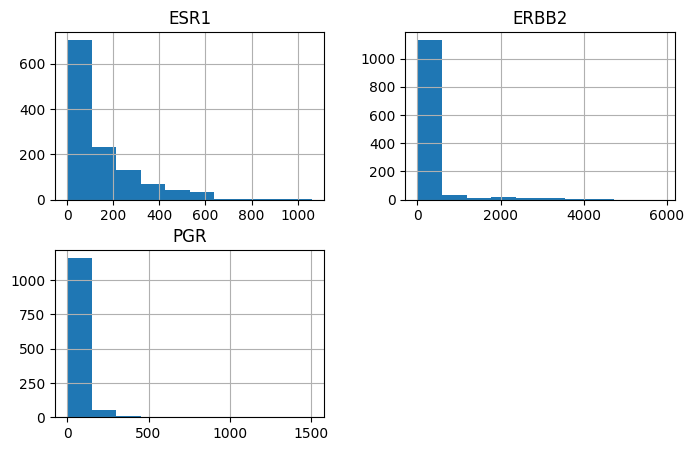

In [10]:
# Extract the last 78 columns (gene data)
#gene_data = merged_df.iloc[:, -10:]

# Plot histograms for the selected genes
genes_to_plot = ['ESR1', 'ERBB2', 'PGR']
gene_data = merged_df[genes_to_plot]
gene_data.hist(figsize=(8, 5))
plt.show()

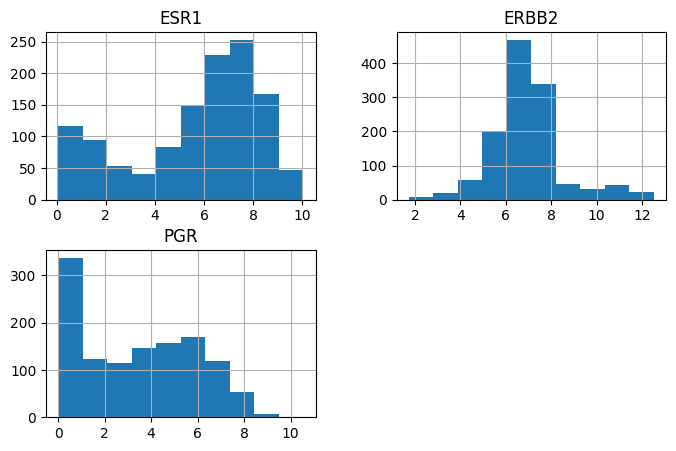

In [11]:
# Perform log2-transformation after adding 1 to each TPM value
log2_gene_data = np.log2(gene_data + 1)
log2_gene_data.hist(figsize=(8, 5))
plt.show()

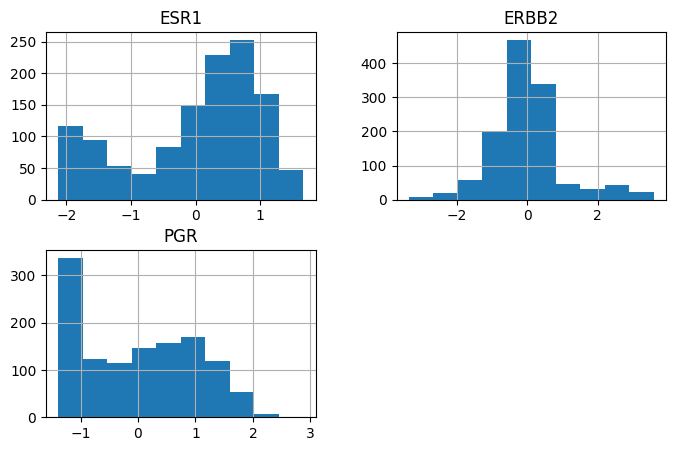

In [12]:
# Apply Z-score normalization for each gene across all samples
z_score_gene_data = log2_gene_data.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
z_score_gene_data.hist(figsize=(8, 5))
plt.show()

In [14]:
# Create a copy of the original dataframe
merged_norm_df = merged_df.copy()

# Select all gene data (last 60660 columns)
all_gene_data = merged_norm_df.iloc[:, -60660:]

# Perform log2 transformation and Z-score normalization in one step
merged_norm_df.iloc[:, -60660:] = (np.log2(all_gene_data + 1) - all_gene_data.mean()) / all_gene_data.std()
display(merged_norm_df.head())

: 

# 4. EXPLORATORY DATA ANALYSIS (EDA) <a name="4"></a>

In [13]:
# Use merged_norm_df